# Example: Target Speech Separation with DPRNN

In this example notebook, we will use one of the pre-trained models to separate the target voice from an audio mix.

## Prerequisites
Firstly, let's install all the required packages.

In [1]:
%%capture
pip install -r requirements.txt

In [2]:
import numpy as np

import torch
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import display, Audio

from src.models.dprnn_spe import DPRNNSpeTasNet
from src.models.dprnn_spe_ira import DPRNNSpeIRATasNet
from src.models.dprnn_rawnet import DPRNNRawNetTasNet
from src.datasets.librimix_spe import LibrimixSpe

## Model Overview

We will be using the DPRNN-Spe model with attention-based fusion for this demonstration. However, you can use other fusion techniques by replacing the `fusion_type` and `checkpoint_path`. The following additional models are available:

* DPRNN-Spe-IRA (only `cat`)
* DPRNN-RawNet (only `att`)

In [4]:
model = DPRNNSpeTasNet(
    input_size=64,
    feature_size=128,
    hidden_size=128,
    chunk_length=250,
    kernel_size=2,
    hop_length=125,
    n_repeats=6,
    bidirectional=True,
    norm_type='ln',
    activation_type='sigmoid',
    dropout=0,
    O=128,
    P=256,
    embeddings_size=128, # Note: 256 if using the DPRNN-RawNet model.
    num_spks=251,
    fusion_type='att', # or 'add', 'cat', 'film', 'mul'
)

In [5]:
checkpoint_path = './chkpts/dprnn-spe/best_attention.pt' # or 'best_addition', 'best_concatenation', 'best_FiLM', 'best_multiplication'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

## Dataset

For this demonstration, we will use the [MiniLibriMix](https://zenodo.org/records/3871592) dataset (~640 MB). The installation will occur in the current folder (may take a couple of minutes). We will use only the `val` dataset because the `train` dataset does not have enough mixtures to provide references for each mixture.

In [6]:
data = LibrimixSpe.mini_from_download(batch_size=1, segment=3)
sample_rate=8000

100%|██████████| 611M/611M [00:56<00:00, 11.3MB/s] 


Drop 0 utterances from 200 (shorter than 3 seconds)
speakers cnt:  39


In [8]:
len(data)

200

## Target Speech Extraction

In the next cell, we will extract the target speech based on the provided reference.

In [9]:
mix, target, reference, _ = data[1] # < len(data)
ref_len = torch.tensor(reference.shape[0], dtype=torch.float32)
model.eval()
est, _= model(mix.unsqueeze(0), reference.unsqueeze(0), ref_len) # Note: Do not pass ref_len if using the DPRNN-RawNet model.

You can visualize the extraction results as magnitude spectrograms:

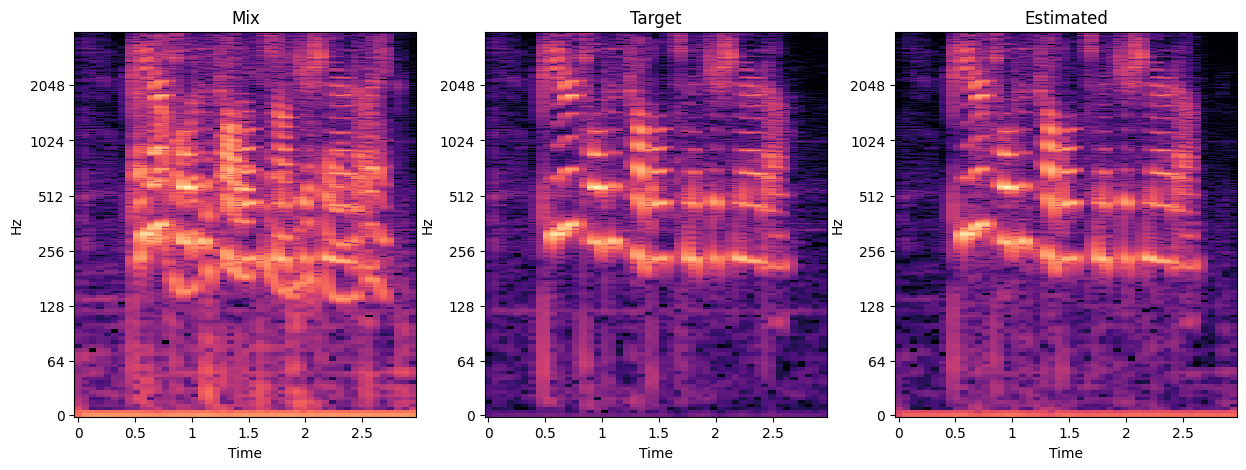

In [10]:
def show_magspec(waveform, sr=8000, ax=None, **kw):
    if waveform.size == 0 or np.all(waveform == 0):
        print("Empty or silent waveform provided.")
        return
    
    D = librosa.stft(waveform)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, y_axis='log', x_axis='time', ax=ax, **kw)
    return img

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

mix_np = mix.numpy()
target_np = target.numpy()
est_np = est.squeeze(0).detach().numpy()

show_magspec(mix_np, sr=8000, ax=ax[0])
ax[0].set_title('Mix')
show_magspec(target_np, sr=8000, ax=ax[1])
ax[1].set_title('Target')
show_magspec(est_np, sr=8000, ax=ax[2])
ax[2].set_title('Estimated')

plt.show()

It can also be useful to compare the audios themselves:

In [11]:
print("Mix Audio:")
display(Audio(mix_np, rate=sample_rate))

print("Target Audio:")
display(Audio(target_np, rate=sample_rate))

print("Estimated Audio:")
display(Audio(est_np, rate=sample_rate))

print("Reference Audio:")
display(Audio(reference, rate=sample_rate))

Mix Audio:


Target Audio:


Estimated Audio:


Reference Audio:
